Повторим некоторые действия из файла sklearn_classification.ipynb

In [24]:
from sklearn.datasets import load_iris
# загрузка данных iris dataset:
data = load_iris()
# извлечение признаков и меток:
X = data['data']
y = data['target']

In [25]:
import numpy as np

# метки для бинарной классификации:
y_virg = np.ones_like(y)
for i in range(len(y)):
    if y[i] < 2:
        y_virg[i] = -1
# y_virg = (y == 2)
y_virg

X_reduced = X[:, (1, 2)]

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_reduced, y_virg,
                                                    test_size=0.2,
                                                    random_state=40)

In [27]:
from sklearn.linear_model import SGDClassifier
# создание и обучение линейного классификатора
sgd_clf = SGDClassifier(random_state=44)
sgd_clf.fit(X_train, y_train)

SGDClassifier(random_state=44)

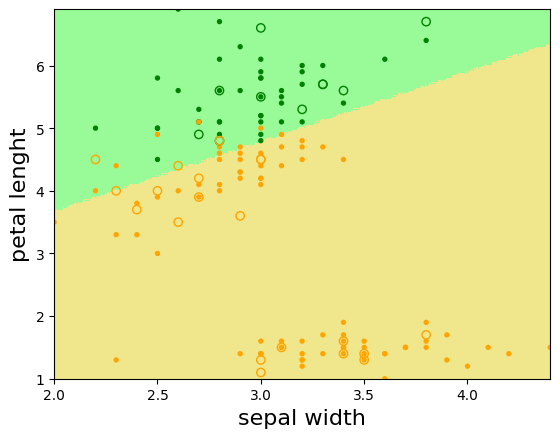

In [28]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# найдем граничные значения признаков
x1_min, x2_min = np.min(X_reduced, axis=0)
x1_max, x2_max = np.max(X_reduced, axis=0)

resolution = 200    # число, на которое будет разбиваться диапазон

# создаются массивы значений для осей абсцисс и ординат
x1_values = np.linspace(x1_min, x1_max, resolution)
x2_values = np.linspace(x2_min, x2_max, resolution)
x1_grid, x2_grid = np.meshgrid(x1_values, x2_values)

y_grid = np.zeros_like(x1_grid, dtype=np.int8)

# генерируются метки для соответствуюхи пар признаков и
# записываются в массив z_grid
for i in range(resolution):
    for j in range(resolution):
        instance = np.array([[x1_grid[i, j], x2_grid[i, j]]])
        y_grid[i, j] = sgd_clf.predict(instance)

plt.contourf(x1_grid, x2_grid, y_grid, colors=['khaki', 'palegreen'])

colors = ["green" if y_train[i]==1 else "orange" for i in range(len(y_train))]
plt.scatter(X_train[:, 0], X_train[:, 1], c=colors, s=8)

colors = ["green" if y_test[i]==1 else "orange" for i in range(len(y_test))]
plt.scatter(X_test[:, 0], X_test[:, 1], edgecolors=colors, facecolors='none')

plt.xlabel("sepal width", fontsize=16)
plt.ylabel("petal lenght", fontsize=16)
plt.show()

## Как линейный классификатор делает прогнозы

Мы говорили, что в случае бинарной классификации метод `decision_function()` возвращает некоторую оценку (score) для каждого образца. Тогда по этой оценке можно приняте решение о принадлежности образца к тому или иному классу. Например, будем считать, что результат больше 0, то значит прогнозируется положительный класс, в противном случае - отрицательный. В этом случае значение 0 является пороговым (threshold). Именно так по умолчанию модель класса `SGDClassifier` прогнозирует, к какому классу относится образец. 

In [29]:
index = 3
score = sgd_clf.decision_function([X_test[index]])
label = sgd_clf.predict([X_test[index]])
print(f"{X_test[index]}\n{score = }\n{label = }")

[3.8 6.7]
score = array([112.27270929])
label = array([1])


Как функция `decision_function()` высчитывает значение `score` по данным значениям признаков? Пусть $x_1, \ldots, x_d$ - значения признаков некоторого образца. Значение `score` считается по формуле
$$
y = a + b_1 x_1 + \dots + b_d x_d
$$
В данном случае признаков всего два $(x_1, x_2)$, так что формула имеет вид:
$$
y = a + b_1 x_1 + b_2 x_2
$$
Такая формула называется уравнением плоскости, и, действительно, она описывает расположение плоскости в трехмерном пространстве (с осями $x_1, x_2, y$). Выходит, что внутри модели подгоняются всего три параметра $a, b_1, b_2$, которые определяют плоскость в пространстве, хотя по визуализации решающей границы казалось, что модель строит прямую, а не плоскость.

Получить доступ к параметрам можно через поля `intercept_` и `coef_`:

In [30]:
sgd_clf.intercept_, sgd_clf.coef_

(array([-162.11099918]), array([[-124.3301179 ,  111.46838156]]))

Сохраним параметры в переменных `a`, `b_1` и `b_2` соответственно.

In [31]:
a = sgd_clf.intercept_[0]
b_1, b_2 = sgd_clf.coef_[0]

a, b_1, b_2

(-162.1109991752636, -124.33011789924916, 111.46838156484414)

Теперь, при помощи этих значений, мы можем сами посчитать то же, что и высчитывается в функции `decision_funcition()` воспользовавшись уравнением плоскости. Посчитаем `score` для образца выборки с индексом `index`:

In [32]:
x_1, x_2 = X_reduced[index]

In [33]:
a + x_1*b_1 + x_2*b_2

-380.3317923156698

Сравним со значением `score`, полученным непосредственно функцией `decision_funcition()`.

In [34]:
sgd_clf.decision_function([X_reduced[0]])


array([-441.21067763])

Теперь, зная параметры, построим плоскость, и посмотрим, как она позволяет классифицировать и каков геометрический смысл значения, возвращаемого функцией `decision_funcition()`.

Для интерактивной визуализации трехмерного графика в отдельном окне может потребоваться установка модуля PyQt5:<br>
`pip install pyqt5`<br>
Для того, чтобы визуализация произошла в отдельном окне следует прописать в начале секции <br>
`%matplotlib qt`

In [35]:
y_grid = np.zeros_like(x1_grid)
for i in range(resolution):
    for j in range(resolution):
        instance = np.array([[x1_grid[i, j], x2_grid[i, j]]])
        y_grid[i, j] = sgd_clf.decision_function(instance)

In [36]:
threshold = 0

%matplotlib qt

ax = plt.figure().add_subplot(projection='3d')
# отрисовка 3D поверхности (плоскости) по параметрам модели
ax.plot_surface(x1_grid, x2_grid, y_grid, edgecolor='lightsteelblue', 
                lw=0.5, rstride=16, cstride=16, alpha=0.1)
# отрисовка горизонтальной плоскости на уровне y=threshold
ax.plot_surface(x1_grid, x2_grid, y_grid*0+threshold, edgecolor='silver',
                facecolor="silver", lw=0.5, rstride=32, cstride=32, alpha=.1)

# отрисовка точек выборки
colors = ["green" if y_virg[i]==1 else "orange" for i in range(len(y_virg))]
y_threshold = np.full(len(X_reduced), threshold)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], y_threshold, c=colors, s=12)

# отрисовка оранжевой проекции
index = 3
dots = np.full((3, 2), fill_value=threshold, dtype=np.float32)
dots[:2, 0] = X_reduced[index]
dots[:2, 1] = X_reduced[index]
dots[2, 1] = sgd_clf.decision_function([X_reduced[index]])
plt.plot(dots[0], dots[1], dots[2], '--', c="orange")
plt.plot(dots[0, 1], dots[1, 1], dots[2, 1], marker="o",
    markersize=4, markeredgecolor='orange', markerfacecolor='none')

# отрисовка зеленой проекции
index = 117
dots = np.full((3, 2), fill_value=threshold, dtype=np.float32)
dots[:2, 0] = X_reduced[index]
dots[:2, 1] = X_reduced[index]
dots[2, 1] = sgd_clf.decision_function([X_reduced[index]])
plt.plot(dots[0], dots[1], dots[2], '--', c="green")
plt.plot(dots[0, 1], dots[1, 1], dots[2, 1], marker="o",
    markersize=4, markeredgecolor='green', markerfacecolor='none')

# создадим точки для рисования линии пересечения плоскости
# модели с плоскостью на уровне y=0
dot1 = np.full(3, fill_value=threshold, dtype=np.float32)
dot2 = np.full(3, fill_value=threshold, dtype=np.float32)
dot1[0] = x1_min
dot1[1] = threshold/b_2 - (a/b_2) - (b_1*x1_min)/b_2
dot2[0] = x1_max
dot2[1] = threshold/b_2 - a/b_2 - b_1*x1_max/b_2
dots = np.vstack((dot1, dot2))
ax.plot(dots[:, 0], dots[:, 1], dots[:, 2], linestyle='--', c='slategrey')
print(dots)

ax.grid(False)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y')

[[2.        3.685092  0.       ]
 [4.4       6.3620152 0.       ]]


Text(0.5, 0, 'y')

Из полученной трехмерной визуализации можно видеть, что плоскость расположена так, что оранжевые точки расположены преимущественно выше плоскости, а зеленые - ниже. Серая плоскость - горизонтальная, на уровне нуля (для всех точек этой плоскости $y=0$), и все точки образцов расположены на ней. 

Но что если выбрать другое значение порога? Пусть порог `threshold` будет равен `50`. Это значит, что образец будет отнесен к положительному классу, если значение `score` больше 20, в противном случае образец будет отнесен к отрицательному классу. Геометрически это означает, что серая плоскость и все точки подниматься вверх на 20 единиц. Тогда и прямая персечения плоскостей несколько сдвинется. Это эквивалентно тому, что мы сдвинули бы синюю плоскость вниз на `50` единиц.

Если провести строго вертикальную линию от точки на серой плоскости до пересечения с синей плоскостью, получим отрезок, характеризующий высоту соответствующей точки на синей плоскости (можно видеть два не закрашенных кружка на синей плоскости). Это и есть то значение, которое возращается методом `decision_function()` для образца выборки. Знак определяется расположением точки на синей плоскости. Если она ниже уровня 0 (т.е. ниже серой плоскости), то знак будет отрицательный, если выше - положительный.

## Визуализация Логистической регрессии

In [37]:
from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression()
log_clf.fit(X_train, y_train)

LogisticRegression()

In [38]:
a = log_clf.intercept_[0]
b_1, b_2 = log_clf.coef_[0]

In [39]:
y_grid = np.zeros_like(x1_grid)
y_grid_df = np.zeros_like(x1_grid)
for i in range(resolution):
    for j in range(resolution):
        instance = np.array([[x1_grid[i, j], x2_grid[i, j]]])
        y_grid[i, j] = log_clf.predict_proba(instance)[0, 0]
        # y_grid_df[i, j] = log_clf.decision_function(instance)

In [40]:
threshold = 0.5

%matplotlib qt

ax = plt.figure().add_subplot(projection='3d')
# отрисовка 3D поверхности (плоскости) по параметрам модели
ax.plot_surface(x1_grid, x2_grid, y_grid, edgecolor='lightsteelblue', 
                lw=0.5, rstride=16, cstride=16, alpha=0.1)
# отрисовка горизонтальной плоскости на уровне y=threshold
ax.plot_surface(x1_grid, x2_grid, y_grid*0+threshold, edgecolor='silver',
                facecolor="silver", lw=0.5, rstride=32, cstride=32, alpha=.1)

# отрисовка точек выборки
colors = ["green" if y_virg[i]==1 else "orange" for i in range(len(y_virg))]
y_threshold = np.full(len(X_reduced), threshold)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], y_threshold, c=colors, s=12)

# отрисовка оранжевой проекции
index = 3
dots = np.full((3, 2), fill_value=threshold, dtype=np.float32)
dots[:2, 0] = X_reduced[index]
dots[:2, 1] = X_reduced[index]
dots[2, 1] = log_clf.predict_proba([X_reduced[index]])[0, 0]
plt.plot(dots[0], dots[1], dots[2], '--', c="orange")
plt.plot(dots[0, 1], dots[1, 1], dots[2, 1], marker="o",
    markersize=4, markeredgecolor='orange', markerfacecolor='none')

# отрисовка зеленой проекции
index = 117
dots = np.full((3, 2), fill_value=threshold, dtype=np.float32)
dots[:2, 0] = X_reduced[index]
dots[:2, 1] = X_reduced[index]
dots[2, 1] = log_clf.predict_proba([X_reduced[index]])[0, 0]
plt.plot(dots[0], dots[1], dots[2], '--', c="green")
plt.plot(dots[0, 1], dots[1, 1], dots[2, 1], marker="o",
    markersize=4, markeredgecolor='green', markerfacecolor='none')

# создадим точки для рисования линии пересечения плоскости
# модели с плоскостью на уровне y=0
dot1 = np.full(3, fill_value=threshold, dtype=np.float32)
dot2 = np.full(3, fill_value=threshold, dtype=np.float32)
dot1[0] = x1_min
dot1[1] = - (a/b_2) - (b_1*x1_min)/b_2
dot2[0] = x1_max
dot2[1] = - a/b_2 - b_1*x1_max/b_2
dots = np.vstack((dot1, dot2))
ax.plot(dots[:, 0], dots[:, 1], dots[:, 2], linestyle='--', c='slategrey')

ax.grid(False)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y')

Text(0.5, 0, 'y')